## Data preparation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [88]:
data_full = pd.read_excel('data.xlsx')
data = data_full.drop(columns='Name')
X, y = data.drop(columns='Target'), data.Target
n_data = data.shape[0]
print(n_data)
data.head()

60


,DSRI,GMI,AQI,SGI,SGAI,LVGI,Target
0,0.136,0.000,106.500,1527.000,1.00,1562.000,1
1,0.520,1.613,26792.000,1.594,1.18,0.980,1
2,1.136,1.290,1.258,1.323,0.94,0.942,1
3,10.781,0.029,1.015,0.110,10.30,1.237,1
4,3.813,0.210,0.663,0.483,3.79,2.883,1


In [234]:
def calc_metrics(y_true, y_pred, print_res=True):
    TP = (y_pred[y_true == 1] == 1).sum()
    FP = (y_pred[y_true == 0] == 1).sum()
    TN = (y_pred[y_true == 0] == 0).sum()
    FN = (y_pred[y_true == 1] == 0).sum()

    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    F1 = 2 * precision * recall / (precision + recall)
    
    if print_res:
        # print(f'{TP=}, {FP=}, {TN=}, {FN=}')
        print(f'accuracy   = {accuracy:.3f}')
        print(f'precision  = {precision:.3f}')
        print(f'recall     = {recall:.3f}')
        print(f'F1         = {F1:.3f}')
    else:
        return accuracy, precision, recall, F1
    
def calc_F1(y_true, y_pred):
    TP = (y_pred[y_true == 1] == 1).sum()
    FP = (y_pred[y_true == 0] == 1).sum()
    FN = (y_pred[y_true == 1] == 0).sum()
    
    if TP + (FP + FN)/2:
        return TP / (TP + (FP + FN)/2)
    else:
        return 0

## Model validation

In [158]:
BENEISH_MODEL = {
    'const': -4.84,
    'DSRI': 0.92,
    'GMI': 0.528,
    'AQI': 0.404,
    'SGI': 0.892,
    'SGAI': -0.172,
    'LVGI': -0.327,
}
beneish_model_df = pd.DataFrame(BENEISH_MODEL, index=(0,))

def calculate_critical_m_score(X, y):
    X1 = sm.add_constant(X)
    X1_honest = X1[y == 0]
    critical_m_score = (X1_honest.mean() * beneish_model_df.loc[0]).sum()
    return critical_m_score
    
def rus_beneish_predict(X, critical_m_score):
    X1 = sm.add_constant(X)
    X1 *= beneish_model_df.loc[0]
    X1_M_score = X1.sum(axis=1)
    prediction = (X1_M_score > critical_m_score).astype(int)
    return prediction

In [160]:
critical_m_score = calculate_critical_m_score(X, y)
calc_metrics(y, rus_beneish_predict(X, critical_m_score))

accuracy   = 0.683
precision  = 0.667
recall     = 0.643
F1         = 0.655


Бутстрэпом проверим насколько такому классификатору вообще можно доверять

## Bootstrap

In [151]:
def get_bootstrap_sample(X, y):
    """Generate bootstrap samples using the bootstrap method."""    
    indices = np.random.randint(0, y.size, size=y.size)
    return X.iloc[indices], y.iloc[indices]

def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries

In [311]:
def bootstrap_confidential_interval_F1(X, y, classifier, classifier_param_estimator, 
                                       n_samples=1000, alpha=0.05, random_state=10):
    np.random.seed(random_state)
    F1_scores = np.empty(n_samples)
    for i in range(n_samples):
        X_b, y_b = get_bootstrap_sample(X, y)
        critical_value = classifier_param_estimator(X_b, y_b)
        F1_scores[i] = calc_F1(y_b, classifier(X_b, critical_value))

    return stat_intervals(F1_scores, alpha)

In [312]:
bootstrap_confidential_interval_F1(X, y, rus_beneish_predict, calculate_critical_m_score)

array([0.49054678, 0.7924691 ])

А может мы угадали хорошее значение $M-score$ и лучше его каждый раз не пересчитывать?

In [313]:
def bootstrap_confidential_interval_F1(X, y, classifier, 
                                       n_samples=1000, alpha=0.05, random_state=10):
    np.random.seed(random_state)
    F1_scores = np.empty(n_samples)
    for i in range(n_samples):
        X_b, y_b = get_bootstrap_sample(X, y)
        critical_value = -1.8
        F1_scores[i] = calc_F1(y_b, classifier(X_b, critical_value))

    return stat_intervals(F1_scores, alpha)

In [315]:
bootstrap_confidential_interval_F1(X, y, rus_beneish_predict)

array([0.48977324, 0.78125   ])

Лучше не стало!

## Regular linear model

In [6]:
from sklearn.linear_model import LinearRegression

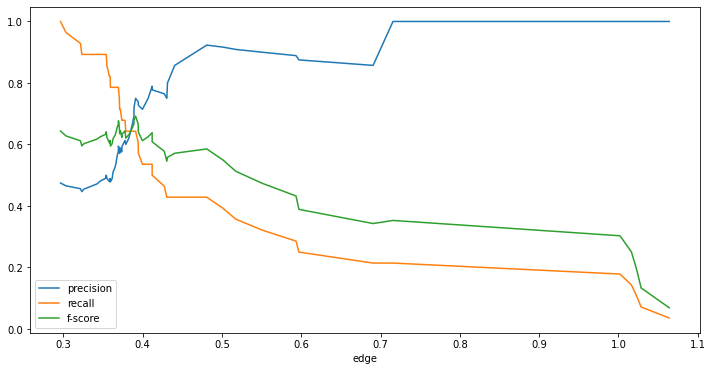

In [326]:
classifier = LinearRegression().fit(X, y)
linear_prediction = classifier.predict(X)

predictive_power_metrics = np.empty((n_data-1, 3))
edges = np.sort(linear_prediction)[:-1]
i = 0
for edge in edges:
    prediction = linear_prediction > edge
    predictive_power_metrics[i] = calc_metrics(y, prediction, print_res=0)[1:]
    i += 1

plt.figure(figsize=(12,6))
plt.plot(edges, predictive_power_metrics[:,0], label='precision')
plt.plot(edges, predictive_power_metrics[:,1], label='recall')
plt.plot(edges, predictive_power_metrics[:,2], label='f-score')
plt.legend()
plt.xlabel('edge')
plt.show()

In [320]:
edge = edges[np.argmax(predictive_power_metrics[:,2])]
edge

0.39100196870263687

In [9]:
calc_metrics(y, sample_beneish_predict(X))

accuracy   = 0.733
precision  = 0.750
recall     = 0.643
F1         = 0.692


In [345]:
def bootstrap_confidential_interval_F1_linear(X, y, classifier, n_samples=1000, alpha=0.05, random_state=10):
    np.random.seed(random_state)
    F1_scores = np.empty(n_samples)
    for i in range(n_samples):
        X_b, y_b = get_bootstrap_sample(X, y)
        classifier.fit(X_b, y_b)
        prediction_float = classifier.predict(X_b)
        
        F1_scores_sample = np.empty(n_data-1)
        j = 0
        for edge in edges:
            prediction = prediction_float > edge
            F1_scores_sample[j] = calc_F1(y_b, prediction)
            j += 1

        F1_scores[i] = F1_scores_sample.max()

    return stat_intervals(F1_scores, alpha)

In [354]:
bootstrap_confidential_interval_F1_linear(X, y, classifier)

array([0.6071158 , 0.83333333])

## Logistic model

In [349]:
from sklearn.linear_model import LogisticRegression

In [350]:
clf = LogisticRegression().fit(X, y)

calc_metrics(y, clf.predict(X))

accuracy   = 0.783
precision  = 0.941
recall     = 0.571
F1         = 0.711


In [355]:
def bootstrap_confidential_interval_F1_logistic(X, y, n_samples=1000, alpha=0.05, random_state=10):
    np.random.seed(random_state)
    F1_scores = np.empty(n_samples)
    for i in range(n_samples):
        X_b, y_b = get_bootstrap_sample(X, y)
        classifier = LogisticRegression().fit(X_b, y_b)
        F1_scores[i] = calc_F1(y_b, classifier.predict(X_b))

    return stat_intervals(F1_scores, alpha)

In [357]:
bootstrap_confidential_interval_F1_logistic(X, y, random_state=0)

array([0.54054054, 0.86666667])

Результат лучше чем у чисто линейных моделей. Этого следовало ожидать, ведь логистический классификатор призван решать именно такую задачу

## Предпосылки к созданию новой модели классификации

Начнем исследование данных с рассчета взаимных корреляций регрессоров

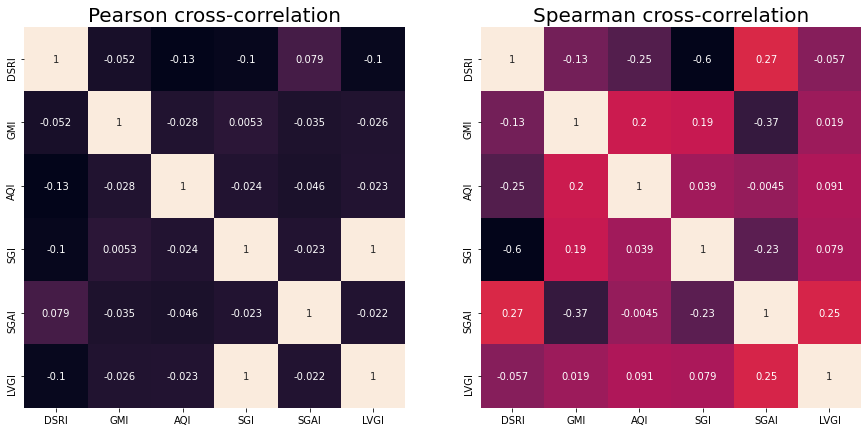

In [55]:
pearson_corr = X.corr(method='pearson')
spearman_corr = X.corr(method='spearman')

fig, ax = plt.subplots(1, 2, figsize=(15,7))
sns.heatmap(pearson_corr, annot=True, cbar=False, ax=ax[0])
sns.heatmap(spearman_corr, annot=True, cbar=False, ax=ax[1])
ax[0].set_title('Pearson cross-correlation', fontsize=20)
ax[1].set_title('Spearman cross-correlation', fontsize=20)
plt.show()

Тут уже очевидно, что линейной моделью такие данные описывать нельзя: LVGI и SGI имеют коэффициент корреляции Пирсона практически равный единице, при этом все коэффициенты корреляции Спирмана находятся "в рамках приличия".

Посмотрим на распределения значений индексов модели Бениша, для этого построим боксплоты для нормированных значений индексов

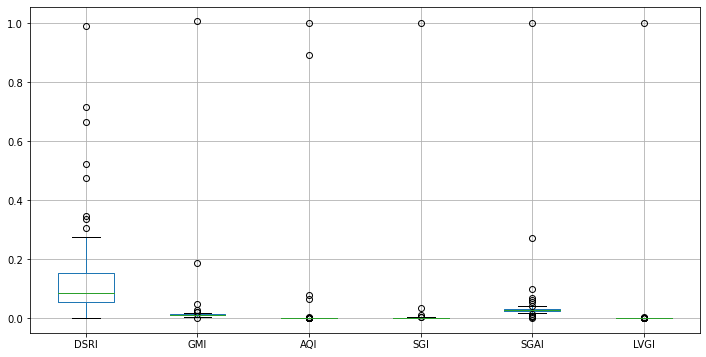

In [60]:
X_scaled = (X - X.min()) / X.max()

fig, ax = plt.subplots(1, figsize=(12,6))
X_scaled.boxplot(ax=ax)
plt.show()

Очевидно, что в данных имеются чрезвычайно выделяющиеся аутлаеры (по сравнению с ними боксплоты почти неразличимы)! 

Приравняем значения всех точек, превышающих 0.9 квантиль к значению этого квантиля и посмотрим на результат:

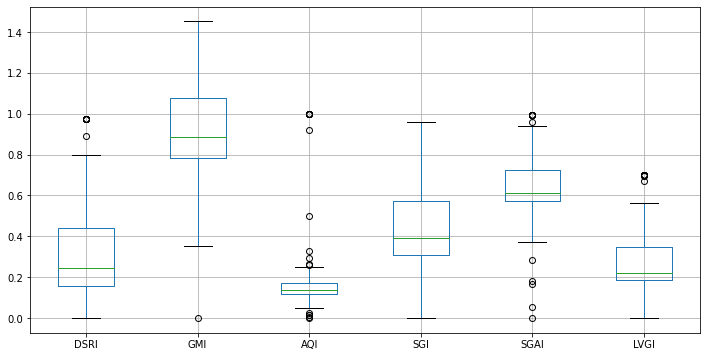

In [61]:
quantile = 0.9
X_cliped = X.clip(lower=None, upper=np.quantile(X, quantile, axis=0))
X_cliped_scaled = (X_cliped - X_cliped.min()) / X_cliped.max()

fig, ax = plt.subplots(1, figsize=(12,6))
X_cliped_scaled.boxplot(ax=ax)
plt.show()

Совсем другое дело! Может быть аутлаеры и есть источник того самого сигнала, который несет информацию о наличии фальсификации и даже линейная модель избыточна?

Попробуем построить классификатор, основанный на отсечке по какому-нибудь квантилю по любому из признаков

## Quantile cutoff

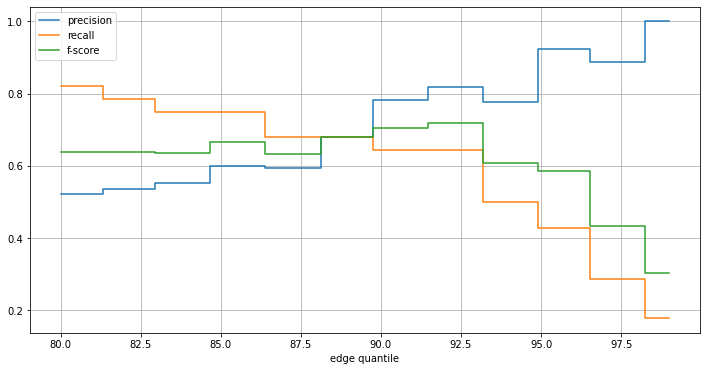

In [353]:
N = 200
i = 0
q_arr = np.linspace(80, 99, N)
predictive_power_metrics = np.empty((N, 3))
for q in q_arr:
    X_quantile = np.quantile(X, q/100, axis=0)
    prediction = (X > X_quantile).any(axis=1)    
    
    predictive_power_metrics[i] = calc_metrics(y, prediction, print_res=0)[1:]
    i += 1

plt.figure(figsize=(12,6))
plt.step(q_arr, predictive_power_metrics[:,0], label='precision')
plt.step(q_arr, predictive_power_metrics[:,1], label='recall')
plt.step(q_arr, predictive_power_metrics[:,2], label='f-score')
plt.legend()
plt.xlabel('edge quantile')
plt.grid()
plt.show()

In [236]:
def calculate_critical_quantile(X, y):
    N = 200
    i = 0
    q_arr = np.linspace(0.8, 0.99, N)
    F1_score = np.empty(N)
    for q in q_arr:
        X_quantile = np.quantile(X, q, axis=0)
        prediction = (X > X_quantile).any(axis=1)    
        
        F1_score[i] = calc_F1(y, prediction)
        i += 1
        
    return np.linspace(0.8, 0.99, N)[F1_score.argmax()]

def quantile_cutoff_classifier(X, critical_quantile):
    X_quantile = np.quantile(X, critical_quantile, axis=0)
    prediction = (X > X_quantile).any(axis=1)
    return prediction

In [227]:
critical_quantile = calculate_critical_quantile(X, y)   
calc_metrics(y, quantile_cutoff_classifier(X, critical_quantile))

accuracy   = 0.767
precision  = 0.818
recall     = 0.643
F1         = 0.720


С помощью bootstrap построим доверительный интервал для $F_1-score$, каждый раз обучая модель на выборочных данных

In [237]:
bootstrap_confidential_interval_F1(X, y, quantile_cutoff_classifier, calculate_critical_quantile)

array([0.57971014, 0.83636364])

Намного лучше исходной модели. Теперь сделаем то же самое, только в качестве граничных значений для индексов будем использовать рассчитанные по оригинальной выборке квантили (это и есть параметры модели, которую мы предлогаем)

In [309]:
incices = ['DSRI', 'GMI', 'AQI', 'SGI', 'SGAI', 'LVGI']
for i in range(6):
    print(f'{incices[i]: <4} cutoff value = {np.quantile(X, 0.925, axis=0)[i]:.3f}')

DSRI cutoff value = 4.616
GMI  cutoff value = 2.629
AQI  cutoff value = 66.542
SGI  cutoff value = 3.039
SGAI cutoff value = 2.251
LVGI cutoff value = 2.118


In [297]:
def bootstrap_confidential_interval_F1_quantile(X, y, n_samples=1000, alpha=0.05, random_state=10):
    np.random.seed(random_state)
    F1_scores = np.empty(n_samples)
    Q = np.quantile(X, 0.925, axis=0)
    for i in range(n_samples):
        X_b, y_b = get_bootstrap_sample(X, y)
        prediction = (X_b > Q).any(axis=1)
        F1_scores[i] = calc_F1(y_b, prediction)

    return stat_intervals(F1_scores, alpha)

In [298]:
bootstrap_confidential_interval_F1_quantile(X, y)

array([0.55813953, 0.84448718])

Наш классификатор по "квантильной отсечке" продемонстрировал лучшее значение $F_1-score$ статистически значимо отличающееся от $0.5$. При этом данная модель проще линейной, а значит её и следовало бы использовать для подобных данных.